This code should do the following:<br>
XXX&nbsp;  1) Take an input temperature and spew back a model spectrum<br>
&nbsp; 2) Take two spectra and compute relevant flux contribution from each, given a filter profile<br>
&nbsp;     3) Compute the adjusted transit depth assuming unocculted spots with the properties above<br>
&nbsp;     4) Take a model transmission spectrum, adjust it according to two parameters:<br>
&nbsp; &nbsp;         Spot Teff (converted to contrast using 1-3)<br>
 &nbsp; &nbsp;        Spot coverage<br>
&nbsp;     5) Compare that model transmission spectrum to observed data inside emcee. <br>

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.timeseries import LombScargle
import astropy.units as u
import healpy as hp
from lightkurve import search_lightcurvefile
from emcee import EnsembleSampler
from multiprocessing import Pool
from corner import corner
from astropy.io import fits
from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter
from multiprocessing import Pool
from scipy import stats
import numpy.random as random
from scipy import optimize
import emcee
import corner
import random

import multiprocessing as mp
Pool = mp.get_context('fork').Pool

In [56]:
plt.rcParams['lines.linewidth']   =3
plt.rcParams['axes.linewidth']    = 2
plt.rcParams['xtick.major.width'] =2
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelweight']='semibold'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['axes.titleweight']='semibold'
plt.rcParams['axes.titlesize']=9

In [57]:
import multiprocessing
import os
from multiprocessing import Pool
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

12 CPUs


In [58]:
def to_str(var):
    if type(var) is list:
        return str(var)[1:-1] # list
    if type(var) is np.ndarray:
        try:
            return str(list(var[0]))[1:-1] # numpy 1D array
        except TypeError:
            return str(list(var))[1:-1] # numpy sequence
    return str(var) # everything else

In [59]:
modelpath = '/Users/andrewmann/Dropbox/Radii/Models_CIFIST_Aug2013_filler.fits'
hdul = fits.open(modelpath)
hdul.info()
hdr = hdul[1].header
data = hdul[1].data

Filename: /Users/andrewmann/Dropbox/Radii/Models_CIFIST_Aug2013_filler.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   1R x 7C   [3760A, 30170102E, 302E, 302E, 302E, 302E, 302E]   


In [60]:
def getspec(data, inteff): ##  for now other parameters are fixed
    teff = np.squeeze(data['teff'])
    logg = np.squeeze(data['logg'])
    afe = np.squeeze(data['a_fe'])
    mh = np.squeeze(data['metal'])
    spectra = np.squeeze(data['spectrum'])
    lambda0 = 100
    nlambda = 99901
    dlambda = 1
    wave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
    loc = np.where((teff == inteff) & (logg == 4.5) & (afe == 0) & (mh == 0))
    if np.size(loc) < 1:
        ## interpolate
        above = np.min(np.where((logg == 4.5) & (afe == 0) & (mh == 0) & (teff > inteff)))
        below = np.max(np.where((logg == 4.5) & (afe == 0) & (mh == 0) & (teff < inteff)))
        spec1 = np.squeeze(spectra[:,above])
        spec2 = np.squeeze(spectra[:,below])
        weight = (inteff-teff[below])/(teff[above]-teff[below])
        spec = (1.-weight)*spec1 + weight*spec2
    else:
        spec = np.squeeze(spectra[:,loc])
    return(spec)

5200.0


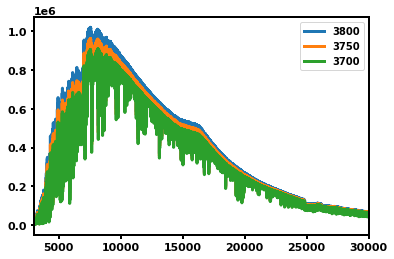

In [61]:
print(np.max(data['teff']))
lambda0 = 100
nlambda = 99901
dlambda = 1
wave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
spec1 = getspec(data,3800)
spec2 = getspec(data,3750)
spec3 = getspec(data,3700)
plt.plot(wave,spec1,label='3800')
plt.plot(wave,spec2,label='3750')
plt.plot(wave,spec3,label='3700')
plt.xlim(3000,30000)
plt.legend()
plt.show()

In [62]:
from scipy import interpolate

def convolve_filter(w,s,fw,ft):
    interpfunc = interpolate.interp1d(w, s, kind='linear')
    interpolflux = interpfunc(fw)
    flux = np.sum(ft*interpolflux)
    return(flux)

HST2
dict_keys(['name', 'wl_min', 'wl_max'])


True

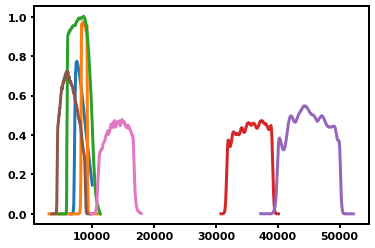

In [63]:
x,y = np.genfromtxt('filters/mearth.tsv', delimiter=';', unpack=True)
x*=10
plt.plot(x,y, label='MEarth')
mearth = TabulatedFilter('mearth', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/pstr-zs-avg.txt', unpack=True)
x*=10
plt.plot(x,y, label='zs')
zs = TabulatedFilter('zs', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/tess-response-function-v1.0.csv', unpack=True, comments='#', delimiter=',')
x*=10
plt.plot(x,y, label='tess')
tess = TabulatedFilter('tess', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/080924ch1trans_full.txt', unpack=True, comments='#', delimiter=',')
x*=10000
plt.plot(x,y, label='Sp1')
s1 = TabulatedFilter('S1', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/080924ch2trans_full.txt', unpack=True, comments='#', delimiter=',')
x*=10000
plt.plot(x,y, label='Sp2')
s2 = TabulatedFilter('S2', x[np.isfinite(y)], y[np.isfinite(y)])

x,y = np.genfromtxt('filters/Kepler_Kepler.K.dat', unpack=True, comments='#', delimiter=',')
#x/=10
plt.plot(x,y, label='Kepler')
kepler = TabulatedFilter('Kepler', x[np.isfinite(y)], y[np.isfinite(y)])

x,y = np.genfromtxt('filters/HST_WFC3_IR.G141.dat', unpack=True, comments='#', delimiter=' ')
#x/=10
plt.plot(x,y, label='G141')
G141 = TabulatedFilter('G141', x[np.isfinite(y)], y[np.isfinite(y)])

## HST bands
b1 = [11108,11416,11709,11988,12257,12522,12791,13058,13321,13586,13860,14140,14425,14719,15027,15345,15682,16042]
b2 = [11416,11709,11988,12257,12522,12791,13058,13321,13586,13860,14140,14425,14719,15027,15345,15682,16042,16432]
b1 = [11108,11773.5,12439,13104.5,13770,14435.5,15101,15766.5]
b2 = [11773.5,12439,13104.5,13770,14435.5,15101,15766.5,16432]
nbins = 8
tmp = np.linspace(10880,16800,nbins+1)
b1 = np.round(tmp[0:nbins])
b2 = np.round(tmp[1:nbins+1])
b1_num = np.array(b1)#/10
b2_num = np.array(b2)#/10
HST_bands = []
hst_names = np.array(b1,dtype=str)
for i in range(0,np.size(b1)):
    str1 = (to_str(round(b1[i])))
    str2 = (to_str(round(b2[i])))
    hst_names[i] = str(str1)+'--'+str(str2)         
counter = 1
for i,j in zip(b1_num,b2_num):
    HST_bands.append(BoxcarFilter('HST'+str(counter),i,j))
    counter=counter+1

    
#print(HST_bands)
filters = HST_bands
filters.append(mearth)
filters.append(kepler)
filters.append(s1)
filters.append(s2)
print(filters[1].name)
fnames = []
for i in range(0,np.size(filters)):
    fnames = np.append(fnames,filters[i].name)
## wl (double-u el) and tm
filters[10].__dict__.keys()
#filters[0].name
#names
#print(G141.tm)
inc = np.squeeze(np.where(fnames == 'HST1'))
print(filters[inc].__dict__.keys())
hasattr(filters[inc],'wl_max')

In [64]:
## given depth (D), spot fraction (fS), and two spectra, compute the adjusted transit depth
def depth_adjust(filt,D,fS,wav,surf,spot):
    star = surf*(1.-fS) + spot*fS
    outoftransit = star
    intransit = (surf-surf*(D/(1.-fS)))*(1.-fS) + spot*fS
    transit = (outoftransit-intransit)/outoftransit
    if hasattr(filt,'wl'):
        wl = filt.wl
        tm = filt.tm
    else:
        wl = np.arange(filt.wl_min,filt.wl_max,1)
        tm = wl*0+1.
    #plt.plot(wav,transit)
    #plt.xlim(np.min(wl),np.max(wl))
    #plt.ylim(D*0.99,D*1.2)
    #plt.show()
    outoftransit_flux = convolve_filter(wav,outoftransit,wl,tm)
    intransit_flux = convolve_filter(wav,intransit,wl,tm)
    #measured = convolve_filter(wav,transit,wl,tm)
    #outoftransit_flux = convolve_filter(wav,outoftransit,wl,tm)
    #intransit_flux = convolve_filter(wav,intransit,wl,tm)
    newD = (outoftransit_flux-intransit_flux)/outoftransit_flux
    return(newD)

In [65]:
lambda0 = 100
nlambda = 99901
dlambda = 1
wave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
star = getspec(data,3800)
spot = getspec(data,3200)

fSpot = 0.4
Depth = 0.0013
print(np.size(filters))
model_depths = []
for i in range(0,np.size(filters)):
    filt = filters[i]
    newD = depth_adjust(filt,Depth,fSpot,wave,star,spot)
    print(filt.name,newD)
    model_depths.append(newD)
# inc = np.squeeze(np.where(fnames == 'tess'))
# wl = filters[inc].wl
# tm = filters[inc].tm
# star2 = star*5
# t3 = convolve_filter(wave,spot,wl,tm)
# t2 = convolve_filter(wave,star,wl,tm)
# t1 = convolve_filter(wave,star2,wl,tm)
# print(t3,t2,t1)

# interpfunc1 = interpolate.interp1d(wave, star, kind='linear')
# interpfunc2 = interpolate.interp1d(wave, star2, kind='linear')
# match1 = interpfunc1(wl)
# match2 = interpfunc2(wl)
# plt.plot(wave,star)
# plt.plot(wl,match1)
# plt.plot(wl,match2)
# print(np.sum(tm*match1))
# print(np.sum(tm*match2))
# plt.xlim(5000,11000)
# plt.show()

12
HST1 0.0015537307656500686
HST2 0.0015410675840854518
HST3 0.0015335860460829612
HST4 0.0015574556089448552
HST5 0.0015861778933558442
HST6 0.0015895128272118266
HST7 0.0015816340061373534
HST8 0.0015617604374257737
mearth 0.0016920541766774543
Kepler 0.001836252984693158
S1 0.0015011488140598448
S2 0.0014495563922237518


In [66]:
## read in some data
depth, err = np.loadtxt('bins_result_run46.dat',unpack=True,skiprows=1)

[ 9.73859273e-05 -1.54620341e-04 -5.51313283e-04 -2.52643330e-04
 -1.68665984e-04 -5.06912360e-04 -1.83717632e-04  9.79448752e-05
  7.07945823e-04  4.06747015e-04 -2.38148814e-04 -1.86556392e-04] [ 0.33723527 -0.6366865  -2.8914833  -1.48544716 -0.80735519 -2.55011013
 -0.83679484  0.49310576  2.83178329  4.06747015 -3.40212592 -2.66509132]


In [67]:
#define functions for MCMC
def ln_prior(theta):
    fS, Tspot, D = theta
    if fS < 0.0 or fS > 1 or Tspot < 2700 or Tspot > 3700 or D < 0 or D > 1:
        return -np.inf
    return 0

def ln_likelihood(theta, depth_obs, depth_err, filters, star, data, swave):
    fS, Tspot, D = theta
    spot = getspec(data,Tspot)
    
    depth_model = []
    for filt in filters:
        newD = depth_adjust(filt,D,fS,swave,star,spot)
        depth_model.append(newD)

    s_squared = np.square(depth_err)
    p = (1. / np.sqrt(2 * np.pi * s_squared)) * np.exp(-np.square(depth_obs - depth_model) / (2 * s_squared)) 
    output = np.sum(np.log(p))
    return output


def ln_posterior(theta, depth_obs, depth_err, filters, star, data, swave):
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_like = ln_likelihood(theta, depth_obs, depth_err, filters, star, data, swave)
    if not np.isfinite(ln_like):
        return -np.inf
    return ln_p + ln_like

In [70]:
nwalkers, ndim = 16, 3
nthreads = 12
initial_guesses = [0.6, 2900, 0.001]
star = getspec(data,3470)
print('if this is inf, we have a problem:')
print(ln_posterior(initial_guesses,depth,err,filters,star,data,wave))
pos0 = [initial_guesses*(1+0.01*np.random.randn(ndim)) for i in range(nwalkers)]

if this is inf, we have a problem:
74.09392951957754


In [71]:
nsteps = 1000
burn = 100
thin = 1

#with Pool() as pool:
#sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(depth,err,filters,data,wave), pool=pool)
#sampler.run_mcmc(pos0, nsteps,progress=True)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(depth,err,filters,star,data,wave), threads=nthreads)
sampler.run_mcmc(pos0, nsteps,progress=True)

print('done')

100%|██████████| 1000/1000 [07:15<00:00,  2.30it/s]

done


(14400, 3)


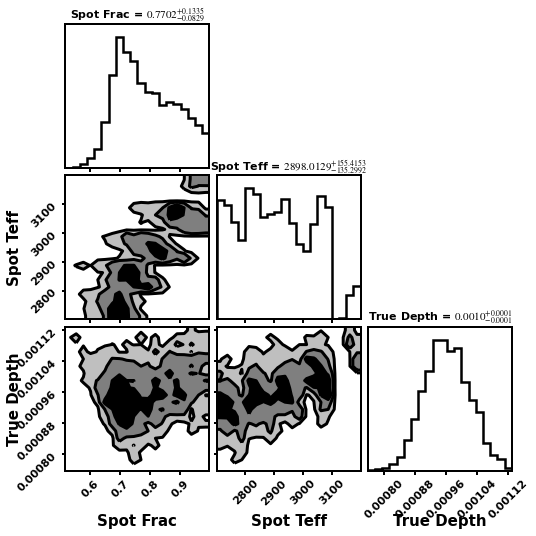

In [72]:
flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
labels = ['Spot Frac','Spot Teff','True Depth']
print(flat_samples.shape)
fig = corner.corner( 
    flat_samples, labels=labels, show_titles=True,
    fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.4f',
    hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
);

plt.show()#savefig('Corner_'+catalog+'_'+adderr+'_'+str(cut)+'_'+str(minsep)+adder+'.pdf')

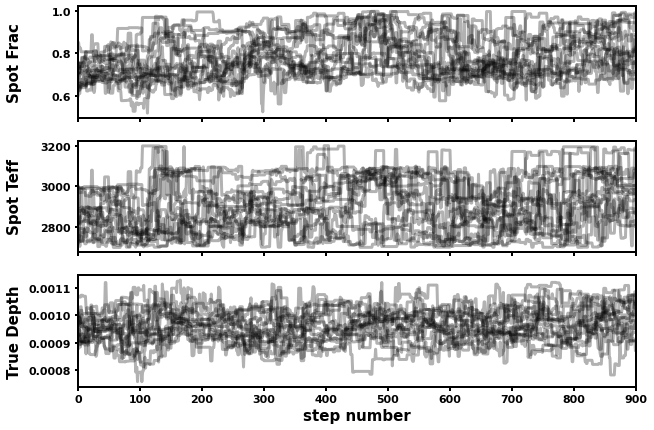

In [73]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burn)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.show()

In [74]:
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    #if i == 0:
    #    mcmc = np.percentile(np.exp(flat_samples[:, i]), [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [75]:
from scipy import integrate
## get out the wavelengths for each:
star = getspec(data,3470)

leffs = []
for i in range(0,np.size(filters)):
    filt = filters[i]
    if hasattr(filt,'wl'):
        fw = filt.wl
        tm = filt.tm
    else:
        fw = np.arange(filt.wl_min,filt.wl_max,1)
        tm = fw*0+1.
    interpfunc = interpolate.interp1d(wave, star, kind='linear')
    interpolflux = interpfunc(fw)
    leff = np.sum(integrate.cumtrapz(fw*tm*interpolflux,fw))/np.sum(integrate.cumtrapz(tm*interpolflux,fw))
    print(filt.name,leff)
    leffs.append(leff)

HST1 11122.993674245936
HST2 11863.927433566716
HST3 12603.474912862217
HST4 13341.215976499561
HST5 14082.77966887957
HST6 14825.346371109854
HST7 15566.226036488471
HST8 16305.42587749475
mearth 8007.274451635966
Kepler 6508.669216997278
S1 34230.523085644694
S2 43135.19742468474


In [77]:
fS = np.percentile(flat_samples[:, 0],[50])
Tspot = np.percentile(flat_samples[:, 1],[50])
D = np.percentile(flat_samples[:, 2],[50])
spot = getspec(data,Tspot)
surf = star
star = surf*(1.-fS) + spot*fS
outoftransit = star
intransit = (surf-surf*(D/(1.-fS)))*(1.-fS) + spot*fS
transit = (outoftransit-intransit)/outoftransit

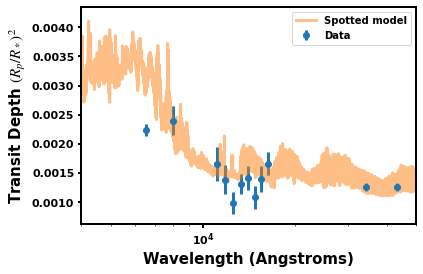

In [82]:
plt.errorbar(leffs, depth, yerr=err, fmt='o',label='Data')
plt.plot(wave,transit,label='Spotted model',alpha=0.5)
plt.xscale('log')
plt.xlim(4000,50000)
plt.ylabel(r'Transit Depth $(R_p/R_*)^2$')
plt.xlabel('Wavelength (Angstroms)')
plt.legend()
plt.show()